# Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM

# Create Data Set

In [2]:
# Load data
path_nod = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NOD.csv')
df_data = pd.read_csv(path_nod, parse_dates=['Date'])

In [3]:
df_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1.96,1.96,1.96,1.96,1.895682,712500
1,2000-01-04,1.88,1.88,1.80,1.88,1.818307,200000
2,2000-01-05,1.76,1.76,1.76,1.76,1.702245,10000
3,2000-01-06,1.76,1.76,1.76,1.76,1.702245,0
4,2000-01-07,1.76,1.84,1.76,1.76,1.702245,260000


In [4]:
df_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6096,2024-01-05,113.099998,113.400002,109.449997,112.150002,112.150002,484783
6097,2024-01-08,112.000000,115.400002,111.650002,115.400002,115.400002,739955
6098,2024-01-09,111.000000,112.000000,108.099998,111.099998,111.099998,945986
6099,2024-01-10,112.800003,113.300003,111.099998,111.250000,111.250000,447778
6100,2024-01-11,112.250000,113.500000,111.500000,111.500000,111.500000,397217


In [5]:
# Split data
split_date = '2021-01-01'
df_train = df_data[df_data['Date'] < split_date]
df_test = df_data[df_data['Date'] >= split_date]

# Select features
x_features = ['Open', 'High', 'Low', 'Close', 'Volume']
y_features = ['Open', 'Close']

df_train_x = df_train[x_features]
df_train_y = df_train[y_features]
df_test_x = df_test[x_features]
df_test_y = df_test[y_features]

In [6]:
# Scale data
# scale_features = ['Open', 'High', 'Low', 'Close', 'Volume']
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_scaled = pd.DataFrame(
#     scaler.fit_transform(df_data.loc[:, scale_features]),
#     columns=scale_features
# )
# df_scaled['Date'] = df_data['Date']

# Scale data
scale_features = ['Open', 'High', 'Low', 'Close', 'Volume']
scale_dict = {}

# Apply normalization on features
for feature in scale_features:
    # Fit on training data column
    scale = MinMaxScaler(feature_range=(0, 1)).fit(df_train_x[[feature]])
    
    df_train_x[feature] = scale.transform(df_train_x[[feature]])
    df_test_x[feature] = scale.transform(df_test_x[[feature]])

    # Transform test data column
    if feature in y_features:
        df_train_y[feature] = scale.transform(df_train_y[[feature]])
        df_test_y[feature] = scale.transform(df_test_y[[feature]])

    # Store the scale for inversion later
    scale_dict[feature] = scale


C:\Users\orjan.carlsen\AppData\Local\Temp\ipykernel_33168\1430499130.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_x[feature] = scale.transform(df_train_x[[feature]])
C:\Users\orjan.carlsen\AppData\Local\Temp\ipykernel_33168\1430499130.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_x[feature] = scale.transform(df_test_x[[feature]])
C:\Users\orjan.carlsen\AppData\Local\Temp\ipykernel_33168\1430499130.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [7]:
df_train_x

,Open,High,Low,Close,Volume
0,0.010762,0.010547,0.011098,0.011050,0.048307
1,0.010180,0.009977,0.009930,0.010468,0.013560
2,0.009308,0.009122,0.009638,0.009596,0.000678
3,0.009308,0.009122,0.009638,0.009596,0.000000
4,0.009308,0.009692,0.009638,0.009596,0.017628
...,...,...,...,...,...
5332,0.923647,0.929447,0.926986,0.934574,0.029344
5333,0.945462,0.935148,0.935748,0.931666,0.023532
5334,0.927283,0.965080,0.930637,0.970922,0.028918
5335,0.984729,1.000000,0.981016,0.995638,0.042341


In [11]:
df_train_y

,Open,Close
0,0.010762,0.011050
1,0.010180,0.010468
2,0.009308,0.009596
3,0.009308,0.009596
4,0.009308,0.009596
...,...,...
5332,0.923647,0.934574
5333,0.945462,0.931666
5334,0.927283,0.970922
5335,0.984729,0.995638


In [8]:
df_test_x

,Open,High,Low,Close,Volume
5337,1.015271,1.015678,1.013143,1.021082,0.061882
5338,1.029087,1.021380,1.008032,1.011631,0.033270
5339,1.024724,1.007127,0.981016,0.984734,0.038046
5340,0.985457,0.977195,0.982477,0.992730,0.043592
5341,1.002909,1.009977,1.007301,1.009450,0.029369
...,...,...,...,...,...
6096,0.818935,0.804732,0.795926,0.812082,0.032868
6097,0.810937,0.818985,0.811989,0.835708,0.050168
6098,0.803665,0.794755,0.786069,0.804449,0.064137
6099,0.816754,0.804019,0.807973,0.805539,0.030359


In [12]:
df_test_y

,Open,Close
5337,1.015271,1.021082
5338,1.029087,1.011631
5339,1.024724,0.984734
5340,0.985457,0.992730
5341,1.002909,1.009450
...,...,...
6096,0.818935,0.812082
6097,0.810937,0.835708
6098,0.803665,0.804449
6099,0.816754,0.805539


In [13]:
# Number of days used for prediction
n_days = 200

# Create training data
x_train = []
y_train = []
for i in range(n_days + 1, df_train_x.shape[0]):
    x_train.append(df_train_x.iloc[i - 1 - n_days:i - 1])
    y_train.append(df_train_y.iloc[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (5136, 200, 5)
y_train shape: (5136, 2)


# Training Model

In [14]:
# Create model
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=y_train.shape[1]))

In [15]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(x_train, y_train, epochs=100, batch_size=32)


Epoch 1/100

161/161 [==============================] - 19s 102ms/step - loss: 0.0027
Epoch 2/100
161/161 [==============================] - 16s 102ms/step - loss: 0.0012
Epoch 3/100
161/161 [==============================] - 16s 102ms/step - loss: 8.1244e-04
Epoch 4/100
161/161 [==============================] - 16s 101ms/step - loss: 7.7643e-04
Epoch 5/100
161/161 [==============================] - 16s 102ms/step - loss: 7.3377e-04
Epoch 6/100
161/161 [==============================] - 17s 103ms/step - loss: 7.5998e-04
Epoch 7/100
161/161 [==============================] - 17s 103ms/step - loss: 7.2491e-04
Epoch 8/100
161/161 [==============================] - 17s 104ms/step - loss: 6.7264e-04
Epoch 9/100
161/161 [==============================] - 17s 103ms/step - loss: 6.1905e-04
Epoch 10/100
161/161 [==============================] - 17s 106ms/step - loss: 5.5827e-04
Epoch 11/100
161/161 [==============================] - 17s 106ms/step - loss: 4.7673e-04
Epoch 12/100
161/161 [===

In [16]:
regressor.save('nod_prediction.keras')

In [17]:
model = load_model('nod_prediction.keras')

# Test Model

In [18]:
# Create testing data
df_test_inputs = pd.concat((df_train_x.iloc[-n_days:], df_test_x), axis=0)


x_test = []
for i in range(n_days + 1, df_test_inputs.shape[0]):
    x_test.append(df_test_inputs.iloc[i - 1 - n_days:i - 1])
x_test = np.array(x_test)


In [19]:
x_test

array([[[0.25014544, 0.25057011, 0.22707362, 0.24876418, 0.09920479],
        [0.25101803, 0.25114025, 0.23525118, 0.23451585, 0.07221319],
        [0.23283886, 0.23489166, 0.22663552, 0.23655132, 0.07948785],
        ...,
        [0.9272833 , 0.96507975, 0.93063674, 0.97092178, 0.02891797],
        [0.98472945, 1.        , 0.98101642, 0.99563822, 0.04234095],
        [1.        , 0.98931015, 1.        , 1.        , 0.01855263]],

       [[0.25101803, 0.25114025, 0.23525118, 0.23451585, 0.07221319],
        [0.23283886, 0.23489166, 0.22663552, 0.23655132, 0.07948785],
        [0.23763816, 0.24857469, 0.23758763, 0.24396627, 0.11431467],
        ...,
        [0.98472945, 1.        , 0.98101642, 0.99563822, 0.04234095],
        [1.        , 0.98931015, 1.        , 1.        , 0.01855263],
        [1.01527055, 1.01567843, 1.01314255, 1.02108167, 0.06188196]],

       [[0.23283886, 0.23489166, 0.22663552, 0.23655132, 0.07948785],
        [0.23763816, 0.24857469, 0.23758763, 0.24396627, 0.1

In [20]:
predictions = regressor.predict(x_test)

24/24 [==============================] - 2s 33ms/step


In [21]:
y_pred = predictions.copy()
y_pred[:, 0] = scale_dict['Open'].inverse_transform(y_pred[:, 0].reshape(-1, 1)).reshape(-1)
y_pred[:, 1] = scale_dict['Close'].inverse_transform(y_pred[:, 1].reshape(-1, 1)).reshape(-1)
# y_pred[:, 0] = scaler.inverse_transform(y_pred[:, 0].reshape(-1, 1)).reshape(-1)
# y_pred[:, 1] = scaler.inverse_transform(y_pred[:, 1].reshape(-1, 1)).reshape(-1)

In [22]:
y_true = df_test_y.copy()
y_true['Open'] = scale_dict['Open'].inverse_transform(y_true['Open'].values.reshape(-1, 1)).reshape(-1)
y_true['Close'] = scale_dict['Close'].inverse_transform(y_true['Close'].values.reshape(-1, 1)).reshape(-1)
# y_true['Open'] = scaler.inverse_transform(y_true['Open'].values.reshape(-1, 1)).reshape(-1)
# y_true['Close'] = scaler.inverse_transform(y_true['Close'].values.reshape(-1, 1)).reshape(-1)

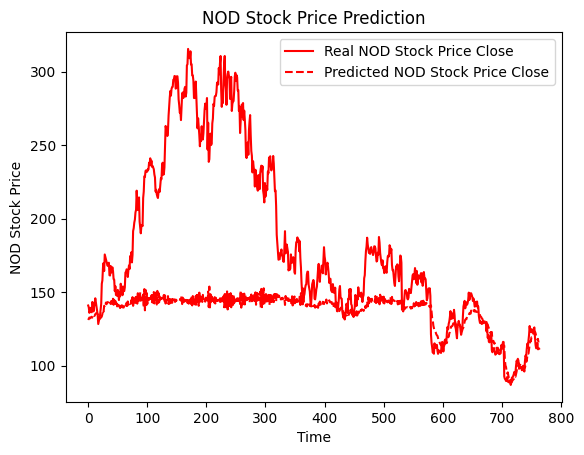

In [24]:
# plt.plot(y_true['Open'].values  , '-' , color='blue', label='Real NOD Stock Price Open')
# plt.plot(y_pred[:, 0]           , '--', color='blue', label='Predicted NOD Stock Price Open')
plt.plot(y_true['Close'].values , '-' , color='red' , label='Real NOD Stock Price Close')
plt.plot(y_pred[:, 1]           , '--', color='red' , label='Predicted NOD Stock Price Close')
plt.title('NOD Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NOD Stock Price')
plt.legend()